## 1. Import Libraries

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

WANDB_API_KEY = os.getenv('WANDB_API_KEY')
os.environ["CUDA_VISIBLE_DEVICES"] = '1,2'
os.environ["WORLD_SIZE"] = '2'

import torch
import torch.nn as nn
import torchvision
import transformers
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import random
import timm
import gc
import requests
import base64
import io
import sys
sys.path.append('..')

from PIL import Image
from pathlib import Path

from PIL import Image
from tqdm import tqdm

from torch.functional import F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

/opt/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Wand Login

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wjnwjn59. Use `wandb login --relogin` to force relogin


True

## 3. Config

In [3]:
config = {
    'seed': 59,
    'learning_rate': 1e-5,
    'epochs': 30,
    'train_batch_size': 32,
    'val_batch_size': 128,
    'hidden_dim': 2048,
    'projection_dim': 2048,
    'weight_decay': 1e-5,
    'patience': 5,
    'text_max_len': 50,
    'fusion_strategy': 'concat+smalllen',
    'text_encoder_id': 'vinai/bartpho-word',
    'img_encoder_id': 'timm/resnet18.a1_in1k', # id from timm
    'paraphraser_id': 'chieunq/vietnamese-sentence-paraphase',
    'num_paraphrase': 2,
    'paraphrase_thresh': 0.9,
    'val_set_ratio': 0.1,
    'dataset': 'ViVQA'
}
PROJECT_NAME = 'vivqa_paraphrase_img_augmentation'
EXP_NAME = f'vivqa_bartpho_resnet18_paran2_geo_augmentation'
EXP_NAME = f'vivqa_bartpho_resnet18_paran{config["num_paraphrase"]}_random_{config["paraphrase_thresh"]}_geo_aug'
wandb.init(
    project=PROJECT_NAME,
    name=EXP_NAME,
    config=config
)

## 4. Set seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

RANDOM_SEED = config['seed']
set_seed(RANDOM_SEED)

## 5. Decode Base 64 Img

In [5]:
import pandas as pd
from PIL import Image
import base64
import io

def decode_image(img_str):
    if pd.isnull(img_str):
        return None
    try:
        img_data = base64.b64decode(img_str)
        image = Image.open(io.BytesIO(img_data))
        return image
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

## 6. Define and get dataset

In [6]:
DATASET_DIR = Path('../../../datasets')
VIVQA_GT_TRAIN_PATH = DATASET_DIR / 'ViVQA' / 'vivqa_train_data.csv'
VIVQA_GT_TEST_PATH = DATASET_DIR / 'ViVQA' / 'vivqa_test_data.csv'

# Absolute path Check 
print("Absolute path to train data:", VIVQA_GT_TRAIN_PATH.resolve())
print("Absolute path to test data:", VIVQA_GT_TEST_PATH.resolve())


Absolute path to train data: /home/VLAI/datasets/ViVQA/vivqa_train_data.csv
Absolute path to test data: /home/VLAI/datasets/ViVQA/vivqa_test_data.csv


In [7]:
def get_data(df_path):
    df = pd.read_csv(df_path)
    questions = [] 
    answers = []
    img_pils = []
    for idx, row in df.iterrows():
        question = row['Question']
        answer = row['Answer']
        img_base64 = base64.b64decode(row['Image'])
        img_pil = Image.open(io.BytesIO(img_base64)).convert('RGB')
    
        questions.append(question)
        answers.append(answer)
        img_pils.append(img_pil)

    return questions, img_pils, answers 


test_questions, test_img_pils, test_answers = get_data(VIVQA_GT_TEST_PATH)    
train_questions, train_img_pils, train_answers = get_data(VIVQA_GT_TRAIN_PATH)

answer_space = set(list(train_answers + test_answers))
idx2label = {idx: label for idx, label in enumerate(answer_space)}
label2idx = {label: idx for idx, label in enumerate(answer_space)}
answer_space_len = len(answer_space)

train_questions, val_questions, train_img_pils, val_img_pils, train_answers, val_answers = train_test_split(train_questions, 
                                                                                                            train_img_pils, 
                                                                                                            train_answers,
                                                                                                            test_size=config['val_set_ratio'],
                                                                                                            shuffle=True,
                                                                                                            random_state=config['seed'])

train_set_size = len(train_questions)
val_set_size = len(val_questions)
test_set_size = len(test_questions)

print(f'Number of train sample: {train_set_size}')
print(f'Number of val sample: {val_set_size}')
print(f'Number of test sample: {test_set_size}')

Number of train sample: 10799
Number of val sample: 1200
Number of test sample: 3001


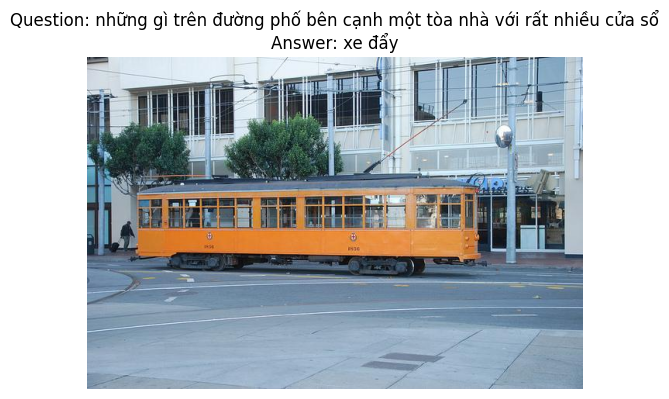

In [8]:
#test
def visualize_sample(question, answer, image):
    if image is not None:
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Question: {question}\nAnswer: {answer}')
        plt.show()
    else:
        print("No image available")

visualize_sample(train_questions[4], train_answers[4], train_img_pils[4])

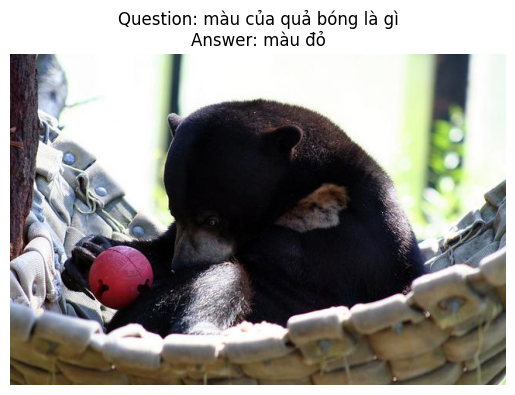

In [9]:
visualize_sample(test_questions[4], test_answers[4], test_img_pils[4])

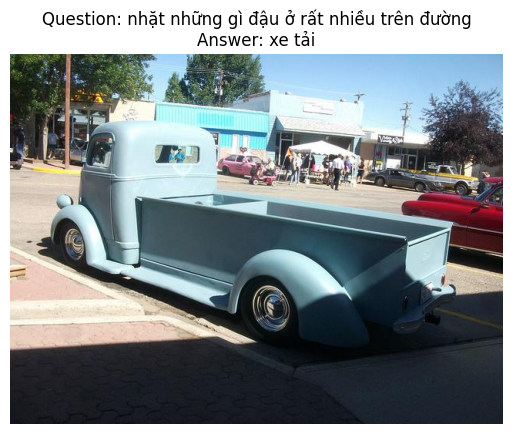

In [10]:
visualize_sample(val_questions[4], val_answers[4], val_img_pils[4])

In [11]:
max([len(text) for text in train_questions + test_questions])

110

## 7. Preprocessing for Text & Image

In [12]:
import py_vncorenlp
from transformers import AutoModel, AutoTokenizer
from contextlib import contextmanager

In [13]:
#Tone Normalization Dictionary and Function
dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def text_tone_normalize(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text

@contextmanager
def temporary_directory_change(directory):
    original_directory = os.getcwd()
    os.chdir(directory)
    try:
        yield
    finally:
        os.chdir(original_directory)

### 7.1 Text Processing Setup

In [14]:
# Text Processing Setup
TEXT_MODEL_ID = config['text_encoder_id']
VNCORENLP_PATH = Path('../models/VnCoreNLP')
ABS_VNCORENLP_PATH = VNCORENLP_PATH.resolve()
os.makedirs(VNCORENLP_PATH, exist_ok=True)

if not (ABS_VNCORENLP_PATH / 'models').exists():
    py_vncorenlp.download_model(save_dir=str(ABS_VNCORENLP_PATH))

with temporary_directory_change(ABS_VNCORENLP_PATH):
    rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], 
                                        save_dir=str(ABS_VNCORENLP_PATH))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
text_encoder_tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_ID)
text_model = AutoModel.from_pretrained(TEXT_MODEL_ID,
                                       device_map=device)

def text_processor(text):
    text = text_tone_normalize(text, dict_map)
    segmented_text = rdrsegmenter.word_segment(text)
    segmented_text = ' '.join(segmented_text)

    input_ids = text_encoder_tokenizer(segmented_text,
                                       max_length=config['text_max_len'],
                                       padding='max_length', 
                                       truncation=True,
                                       return_token_type_ids=False,
                                       return_tensors='pt').to(device)
    
    input_ids = {k: v.squeeze() for k, v in input_ids.items()}

    return input_ids

# def text_processor(texts):
#     texts = [text_tone_normalize(text, dict_map) for text in texts]
#     segmented_texts = [' '.join(rdrsegmenter.word_segment(text)) for text in texts]

#     input_ids = text_encoder_tokenizer(segmented_texts,
#                                        max_length=config['text_max_len'],
#                                        padding='max_length', 
#                                        truncation=True,
#                                        return_token_type_ids=False,
#                                        return_tensors='pt').to(device)
 
#     return input_ids

# sentence = 'Có bao nhiêu người trong bức ảnh ?' 
# phobert_outputs = text_processor(sentence)

# with torch.no_grad():
#     features = text_model(**phobert_outputs)
#     print(features['last_hidden_state'].shape)

2024-07-31 16:49:16 INFO  WordSegmenter:24 - Loading Word Segmentation model


/opt/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
# Test 
text = "Ông Nguyễn Khắc Chúc đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."
segmented_text = rdrsegmenter.word_segment(text)
print("Segmented text:", segmented_text)

Segmented text: ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']


### 7.3 Image Processing Setup

In [16]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

IMG_MODEL_ID = config['img_encoder_id']

# get model specific transforms (normalization, resize)
img_model = timm.create_model(
    IMG_MODEL_ID,
    pretrained=True,
    num_classes=0 # remove classifier nn.Linear
).to(device)
data_config = timm.data.resolve_model_data_config(img_model)
img_processor = timm.data.create_transform(**data_config, 
                                           is_training=False)

# output = img_model(img_processor(image).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor
# or equivalently (without needing to set num_classes=0)


# img_model = img_model.eval()
# with torch.no_grad():
#     output = img_model.forward_features(img_processor(image).to(device).unsqueeze(0))
#     print(output.shape)

## 8. Paraphraser

In [17]:
from transformers import MT5Tokenizer, MT5ForConditionalGeneration

PARAPHRASER_ID = config['paraphraser_id']
paraphraser_tokenizer = MT5Tokenizer.from_pretrained(PARAPHRASER_ID)
paraphraser_model = MT5ForConditionalGeneration.from_pretrained(PARAPHRASER_ID).to(device)

def paraphraser(text, num_return_sequences=3):
    inputs = paraphraser_tokenizer(text, 
                                   padding='longest', 
                                   max_length=64, 
                                   return_tensors='pt',
                                   return_token_type_ids=False).to(device)
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    output = paraphraser_model.generate(input_ids, 
                            attention_mask=attention_mask, 
                            max_length=64,
                            num_beams=5,
                            early_stopping=True,
                            no_repeat_ngram_size=1,
                            num_return_sequences=num_return_sequences)
    
    paraphrase_lst = []
    for beam_output in output:
        paraphrase_lst.append(paraphraser_tokenizer.decode(beam_output, skip_special_tokens=True))
    return paraphrase_lst

# for text in train_questions[:30]:
#     print(f'Input: {text}')
#     print(f'Output: {paraphase(text)}')
#     print('-'*100)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [18]:
#Test
sample_text = "Những người bạn tốt giống như những ngôi sao, bạn chỉ có thể nhận ra họ khi bạn bị bao quanh bởi bóng tối"
paraphrased_texts = paraphraser(sample_text, num_return_sequences=config['num_paraphrase'])
print(paraphrased_texts)

['Những người bạn tốt giống như những ngôi sao, chỉ có thể nhận ra họ khi bị bao vây bởi bóng tối.', 'Những người bạn tốt giống như những ngôi sao chỉ có thể nhận ra họ khi bị bao quanh bởi bóng tối.']


## 9. Image Augmentation 

In [19]:
def augment_image(img_pil, num_augmentations=2):
    augmented_imgs = [] 
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation(degrees=90)
    ])
    for _ in range(num_augmentations):
        augmented_img = transform(img_pil)
        augmented_imgs.append(augmented_img)
    return augmented_imgs

In [20]:
def visualize_sample(question, answer, images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        if i == 0:
            axs[i].set_title(f'Original\nQuestion: {question}\nAnswer: {answer}')
        else:
            axs[i].set_title(f'Augmented {i}')
    plt.show()

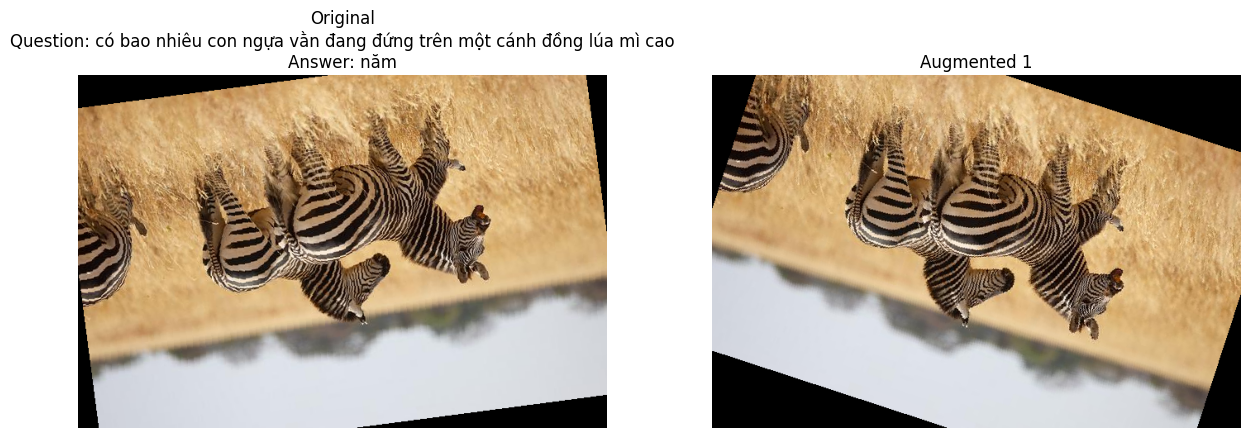

In [21]:
# Test
sample_index = 30
sample_image = train_img_pils[sample_index]
sample_question = train_questions[sample_index]
sample_answer = train_answers[sample_index]

augmented_images = augment_image(sample_image)
visualize_sample(sample_question, sample_answer, augmented_images)

## 9. Dataset and DataLoader

In [22]:
class ViVQADataset(Dataset):
    def __init__(self, questions, img_pils, answers, 
                 data_mode, text_processor, img_processor, 
                 paraphraser, label_encoder=None):
        self.questions = questions
        self.img_pils = img_pils
        self.answers = answers
        self.data_mode = data_mode
        self.text_processor = text_processor
        self.img_processor = img_processor
        self.paraphraser = paraphraser
        self.label_encoder = label_encoder
        self.device = device

    def __getitem__(self, idx):
        question = self.questions[idx]
        answer = self.answers[idx]
        img_pil = self.img_pils[idx]

        # Augment images
        img_inputs_lst = [self.img_processor(img_pil).to(self.device)]
        
        r = random.random()
        if self.data_mode == 'train' and config['num_paraphrase'] > 0:
            augmented_imgs_pil = augment_image(img_pil, config['num_paraphrase'])
            augmented_imgs = [self.img_processor(img).to(self.device) for img in augmented_imgs_pil]

            if r < config['paraphrase_thresh']:
                is_fuse_para_t = torch.ones(img_model.num_features * 7 * 7).to(self.device)
            else:
                is_fuse_para_t = torch.zeros(img_model.num_features * 7 * 7).to(self.device)

            img_inputs_lst += augmented_imgs + [is_fuse_para_t]

        # Process question
        question_inputs = self.text_processor(question)
        label = self.label_encoder[answer]
        labels = torch.tensor(label, dtype=torch.long).to(self.device)

        # Prepare text inputs list
        text_inputs_lst = [question_inputs]

        # Generate paraphrased questions and add to text_inputs_lst
        r = random.random()
        if self.data_mode == 'train' and config['num_paraphrase'] > 0:
            paraphrase_questions = self.paraphraser(question, config['num_paraphrase'])
            paraphrase_inputs_lst = [self.text_processor(text) for text in paraphrase_questions]

            if r < config['paraphrase_thresh']:
                is_fuse_para_t = torch.ones(text_model.config.hidden_size).to(self.device)
            else:
                is_fuse_para_t = torch.zeros(text_model.config.hidden_size).to(self.device)

            text_inputs_lst += paraphrase_inputs_lst + [is_fuse_para_t]

        # Create data outputs
        data_outputs = {
            'text_inputs_lst': text_inputs_lst,
            'img_inputs_lst': img_inputs_lst, 
            'labels': labels
        }

        return data_outputs

    def __len__(self):
        return len(self.questions)

In [23]:
# Define batch sizes
TRAIN_BATCH_SIZE = config['train_batch_size']
VAL_BATCH_SIZE = config['val_batch_size']

# Initialize datasets
train_dataset = ViVQADataset(questions=train_questions,
                             img_pils=train_img_pils,
                             answers=train_answers,
                             data_mode='train',
                             text_processor=text_processor,
                             img_processor=img_processor, 
                             paraphraser=paraphraser,
                             label_encoder=label2idx)

val_dataset = ViVQADataset(questions=val_questions,
                           img_pils=val_img_pils,
                           answers=val_answers,
                           data_mode='val',
                           text_processor=text_processor,
                           img_processor=img_processor, 
                           paraphraser=paraphraser,
                           label_encoder=label2idx)

test_dataset = ViVQADataset(questions=test_questions,
                           img_pils=test_img_pils,
                           answers=test_answers,
                           data_mode='test',
                           text_processor=text_processor,
                           img_processor=img_processor, 
                           paraphraser=paraphraser,
                           label_encoder=label2idx)

# Create data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=TRAIN_BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=VAL_BATCH_SIZE,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=VAL_BATCH_SIZE,
                         shuffle=False)

## 10. Define Model

In [24]:
class TextEncoder(nn.Module):
    def __init__(self, text_model, projection_dim):
        super().__init__()
        for param in text_model.parameters():
            param.requires_grad = True
        self.model = text_model
        self.linear = nn.Linear(self.model.config.hidden_size, projection_dim)

    def forward(self, text_inputs_lst):
        if self.training and config['num_paraphrase'] > 0:
            embed_lst = []
            for text_inputs in text_inputs_lst[:-1]:
                x = self.model(**text_inputs)
                x = x['last_hidden_state'][:, 0, :]
                embed_lst.append(x)
        
            para_features_t = torch.stack(embed_lst[1:], dim=1)
            x = torch.sum(para_features_t, dim=1)
            x *= text_inputs_lst[-1]
            x = x + embed_lst[0]
        else:
            text_inputs = text_inputs_lst[0]
            x = self.model(**text_inputs)
            x = x['last_hidden_state'][:, 0, :]

        x = self.linear(x)
        x = F.gelu(x)

        return x 

class ImageEncoder(nn.Module):
    def __init__(self, img_model, projection_dim):
        super().__init__()
        for param in img_model.parameters():
            param.requires_grad = True
        self.model = img_model
        self.linear = nn.Linear(self.model.num_features * 7 * 7, projection_dim)

    def forward(self, img_inputs_lst):
        if self.training and config['num_paraphrase'] > 0:
            embed_lst = []
            for img_inputs in img_inputs_lst[:-1]:
                x = self.model.forward_features(img_inputs)
                x = x.view(x.size(0), -1)
                embed_lst.append(x)
            img_features_t = torch.stack(embed_lst[1:], dim=1)
            x = torch.sum(img_features_t, dim=1)
            x *= img_inputs_lst[-1]
            x = x + embed_lst[0]
        else: 
            x = self.model.forward_features(img_inputs_lst[0])
            x = x.view(x.size(0), -1)
        
        x = self.linear(x)
        x = F.gelu(x)

        return x

class Classifier(nn.Module):
    def __init__(self, projection_dim, hidden_dim, answer_space):
        super().__init__()
        self.fc = nn.Linear(projection_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(hidden_dim, answer_space)

    def forward(self, text_f, img_f):
        x = torch.cat((img_f, text_f), 1)
        x = self.fc(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.classifier(x)

        return x 

class ViVQAModel(nn.Module):
    def __init__(self, text_encoder, img_encoder, classifier):
        super().__init__()
        self.text_encoder = text_encoder
        self.img_encoder = img_encoder
        self.classifier = classifier

    def forward(self, text_inputs, img_inputs):
        text_f = self.text_encoder(text_inputs)
        img_f = self.img_encoder(img_inputs)
        logits = self.classifier(text_f, img_f)
        return logits


In [25]:
PROJECTION_DIM = config['projection_dim']
HIDDEN_DIM = config['hidden_dim']
text_encoder = TextEncoder(text_model=text_model,
                           projection_dim=PROJECTION_DIM)
img_encoder = ImageEncoder(img_model=img_model,
                         projection_dim=PROJECTION_DIM)
classifier = Classifier(projection_dim=PROJECTION_DIM,
                        hidden_dim=HIDDEN_DIM,
                        answer_space=answer_space_len)

model = ViVQAModel(text_encoder=text_encoder,
                   img_encoder=img_encoder,
                   classifier=classifier)
model = nn.DataParallel(model)
model = model.to(device)

# Test with a batch
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
question = 'Có bao nhiêu con mèo trong bức ảnh?'
batch = next(iter(train_loader))
with torch.no_grad():
    text_inputs_lst = batch.pop('text_inputs_lst')
    img_inputs_lst = batch.pop('img_inputs_lst')
    labels = batch.pop('labels')

    logits = model(text_inputs_lst, img_inputs_lst)
    print(f"Logits shape: {logits.shape}")  

Logits shape: torch.Size([128, 353])


## 11. Training

In [26]:
def save_model(save_path, model):
    os.makedirs('weights', exist_ok=True)
    try:
        state_dict = model.module.state_dict()
    except AttributeError:
        state_dict = model.state_dict()
    torch.save(state_dict, save_path)

def free_vram(model, optimizer):
    del model
    del optimizer
    torch.cuda.empty_cache()
    
LR = config['learning_rate']
EPOCHS = config['epochs']
PATIENCE = config['patience']
WEIGHT_DECAY = config['weight_decay']
SAVE_BEST_PATH = f'./weights/{EXP_NAME}_best.pt'
optimizer = torch.optim.AdamW(model.parameters(),
                             lr=LR,
                             weight_decay=WEIGHT_DECAY)
# step_size = EPOCHS * 0.4
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
#                                             step_size=step_size, 
#                                             gamma=0.1)
criterion = nn.CrossEntropyLoss()

def compute_accuracy(logits, labels):
    _, preds = torch.max(logits, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / logits.size(0)

    return accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    eval_losses = []
    eval_accs = []
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            text_inputs_lst = batch.pop('text_inputs_lst')
            img_inputs_lst = batch.pop('img_inputs_lst')
            labels = batch.pop('labels')

            logits = model(text_inputs_lst, img_inputs_lst)

            loss = criterion(logits, labels)
            acc = compute_accuracy(logits, labels)

            eval_losses.append(loss.item())
            eval_accs.append(acc)

    eval_loss = sum(eval_losses) / len(eval_losses)
    eval_acc = sum(eval_accs) / len(eval_accs)

    return eval_loss, eval_acc


def train(model, 
          train_loader, 
          val_loader, 
          epochs, 
          criterion, 
          optimizer, 
          #scheduler,
          patience=5,
          save_best_path='./weights/best.pt'):
    
    best_val_loss = np.inf
    epochs_no_improve = 0
    
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    for epoch in range(epochs):
        train_batch_loss_lst = []
        train_batch_acc_lst = []

        epoch_iterator = tqdm(train_loader, 
                              desc=f'Epoch {epoch + 1}/{epochs}', 
                              unit='batch')
        model.train()
        for batch in epoch_iterator:
            text_inputs_lst = batch.pop('text_inputs_lst')
            img_inputs_lst = batch.pop('img_inputs_lst')
            labels = batch.pop('labels')

            logits = model(text_inputs_lst, img_inputs_lst)

            loss = criterion(logits, labels)
            acc = compute_accuracy(logits, labels)

            train_batch_loss_lst.append(loss.item())
            train_batch_acc_lst.append(acc)

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            epoch_iterator.set_postfix({'Batch Loss': loss.item()})

        # scheduler.step()

        val_loss, val_acc = evaluate(model,
                                     val_loader,
                                     criterion)

        train_loss = sum(train_batch_loss_lst) / len(train_batch_loss_lst)
        train_acc = sum(train_batch_acc_lst) / len(train_batch_acc_lst)

        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        print(f'EPOCH {epoch + 1}: Train loss: {train_loss:.4f}\tTrain acc: {train_acc:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            save_model(save_best_path, model)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epochs_no_improve} epochs without improvement.')
                break

    return train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst

train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = train(model, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 epochs=EPOCHS, 
                                                                 criterion=criterion, 
                                                                 optimizer=optimizer, 
                                                                 #scheduler=scheduler,
                                                                 patience=PATIENCE,
                                                                 save_best_path=SAVE_BEST_PATH)

Epoch 1/30: 100%|██████████| 85/85 [43:38<00:00, 30.81s/batch, Batch Loss=4.04]


Error: You must call wandb.init() before wandb.log()

## 12. Evaluate

In [ ]:
free_vram(model, optimizer)

text_encoder = TextEncoder(text_model=text_model,
                           projection_dim=PROJECTION_DIM)
img_encoder = ImageEncoder(img_model=img_model,
                         projection_dim=PROJECTION_DIM)
classifier = Classifier(projection_dim=PROJECTION_DIM,
                        hidden_dim=HIDDEN_DIM,
                        answer_space=answer_space_len)
best_model = ViVQAModel(text_encoder=text_encoder,
                        img_encoder=img_encoder,
                        classifier=classifier).to(device)
best_model.load_state_dict(torch.load(SAVE_BEST_PATH))


val_loss, val_acc = evaluate(model=best_model,
                               val_loader=val_loader,
                               criterion=criterion)
val_loss, val_acc = round(val_loss, 4), round(val_acc, 4)

test_loss, test_acc = evaluate(model=best_model,
                               val_loader=test_loader,
                               criterion=criterion)
test_loss, test_acc = round(test_loss, 4), round(test_acc, 4)

print(f'Val loss: {val_loss}\tVal acc: {val_acc}')
print(f'Test loss: {test_loss}\tTest acc: {test_acc}')

Val loss: 2.0333	Val acc: 0.5184
Test loss: 2.1135	Test acc: 0.5078


In [ ]:
exp_table = wandb.Table(
    columns=list(config.keys())+['val_loss', 'val_acc', 'test_loss', 'test_acc'], 
    data=[list(config.values()) + [val_loss, val_acc, test_loss, test_acc]]
)
wandb.log({"Exp_table": exp_table})